## Import Liblary

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
%matplotlib inline
plt.style.use('fivethirtyeight')
import yfinance as yf
np.random.seed(42)

In [ ]:
import pymc as pm
import arviz as az

In [ ]:
print(np.__version__)
print(pm.__version__)
print(az.__version__)

1.26.4
5.10.4
0.18.0


## Function

In [ ]:
def monte_carlo_dcf_simulation(num_scenarios = 10000, prediction_period = 5,
                               initial_FCFF = 10e6, growth_rate = 0.1, std_growth_rate = 0.1,
                               terminal_growth_rata = 0.01, required_rate_of_return = 0.15):

    future_FCFF_li_2d =[]
    present_FCFF_li_2d = []
    present_terminal_value_li = []
    present_value_li = []
    for _ in range(num_scenarios):

        # Cash Flows for the Forecast Period
        future_FCFF = initial_FCFF
        future_FCFF_li =[]
        for i in range(prediction_period):
            future_FCFF = future_FCFF * (1 + np.random.normal(growth_rate, growth_rate * std_growth_rate))
            future_FCFF_li.append(future_FCFF)

        # Present Value of Cash Flows
        present_FCFF_li = []
        for i, fcff in enumerate(future_FCFF_li):
            present_fcff = fcff/ ((1 + required_rate_of_return)**(i+1))
            present_FCFF_li.append(present_fcff)

        # Present Value of Terminal Value
        terminal_value = future_FCFF_li[prediction_period - 1] / (required_rate_of_return - terminal_growth_rata)
        present_terminal_value = terminal_value / ( 1 + required_rate_of_return )**(prediction_period)

        # Present Value
        present_value = sum(present_FCFF_li) + present_terminal_value

        future_FCFF_li_2d.append(future_FCFF_li)
        present_FCFF_li_2d.append(present_FCFF_li)
        present_terminal_value_li.append(present_terminal_value)
        present_value_li.append(present_value)

    # pres_value_median = np.median(present_value_li)
    # pres_value_2_5_per = np.percentile(present_value_li, 2.5)
    # pres_value_5_per = np.percentile(present_value_li, 97.5)
    # pres_value_95_per = np.percentile(present_value_li, 2.5)
    # pres_value_97_5_per = np.percentile(present_value_li, 97.5)

    result = {
        "future_FCFF_li_2d":future_FCFF_li_2d,
        "present_value_li": present_value_li,
        "present_FCFF_li_2d":present_FCFF_li_2d,
        # "present_terminal_value_li":present_terminal_value_li,
        # "wacc": required_rate_of_return,
        # "pres_value_median": pres_value_median,
        # "pres_value_2_5_per": pres_value_2_5_per,
        # "pres_value_5_per": pres_value_5_per,
        # "pres_value_95_per": pres_value_95_per,
        # "pres_value_97_5_per": pres_value_97_5_per
    }

    return result

## Estimation of the Cost of Equity Capital (Estimating the Distribution of β in the CAPM Method Using Bayesian Modeling)

### Prepare Dataset

In [ ]:
# set Kyowa Kirin Co., Ltd. and Nikkei 225
stock_e ='4151.T'
stock_m = '^N225'

# set period
start = pd.to_datetime('2021-03-01')
end = pd.to_datetime('2024-02-29')

# select columns
col_li = ["Adj Close"]

In [ ]:
# get data
data_e = yf.download(stock_e, start=start, end=end)
data_m = yf.download(stock_m, start=start, end=end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
# column extraction
adjClose_e = data_e[col_li].rename(columns={"Adj Close":"adj_close_a"})
adjClose_m = data_m[col_li].rename(columns={"Adj Close":"adj_close_m"})

del data_e
del data_m

In [ ]:
# extracting only the end of the month
M_adjClose_e = adjClose_e.resample("M").last()
M_adjClose_m = adjClose_m.resample("M").last()

# merge
M_adjClose_merge_df = pd.merge(M_adjClose_e, M_adjClose_m, on="Date", how="inner")

# caluculate log return
M_adjClose_merge_df[['a_log_ret','m_log_ret']] = (
    np.log(M_adjClose_merge_df[['adj_close_a','adj_close_m']]
           /M_adjClose_merge_df[['adj_close_a','adj_close_m']]
           .shift(1))
)
M_adjClose_merge_df.dropna(inplace=True)

del adjClose_e
del adjClose_m

In [ ]:
# head and shape
print(f"===== dataframe of {stock_e} (equity)=====")
print(M_adjClose_e.shape)
display(M_adjClose_e.head())

print(f"===== dataframe of {stock_m} (market)=====")
print(M_adjClose_m.shape)
display(M_adjClose_m.head())

print(f"===== dataframe of merge_df=====")
print(M_adjClose_merge_df.shape)
display(M_adjClose_merge_df.head())

===== dataframe of 4151.T (equity)=====
(36, 1)


,adj_close_a
Date,
2021-03-31,3109.640137
2021-04-30,3119.034668
2021-05-31,3109.640137
2021-06-30,3723.294922
2021-07-31,3359.470947


===== dataframe of ^N225 (market)=====
(36, 1)


,adj_close_m
Date,
2021-03-31,29178.800781
2021-04-30,28812.630859
2021-05-31,28860.080078
2021-06-30,28791.529297
2021-07-31,27283.589844


===== dataframe of merge_df=====
(35, 4)


,adj_close_a,adj_close_m,a_log_ret,m_log_ret
Date,,,,
2021-04-30,3119.034668,28812.630859,0.003017,-0.012629
2021-05-31,3109.640137,28860.080078,-0.003017,0.001645
2021-06-30,3723.294922,28791.529297,0.180102,-0.002378
2021-07-31,3359.470947,27283.589844,-0.102826,-0.053796
2021-08-31,3397.270996,28089.539062,0.011189,0.029112


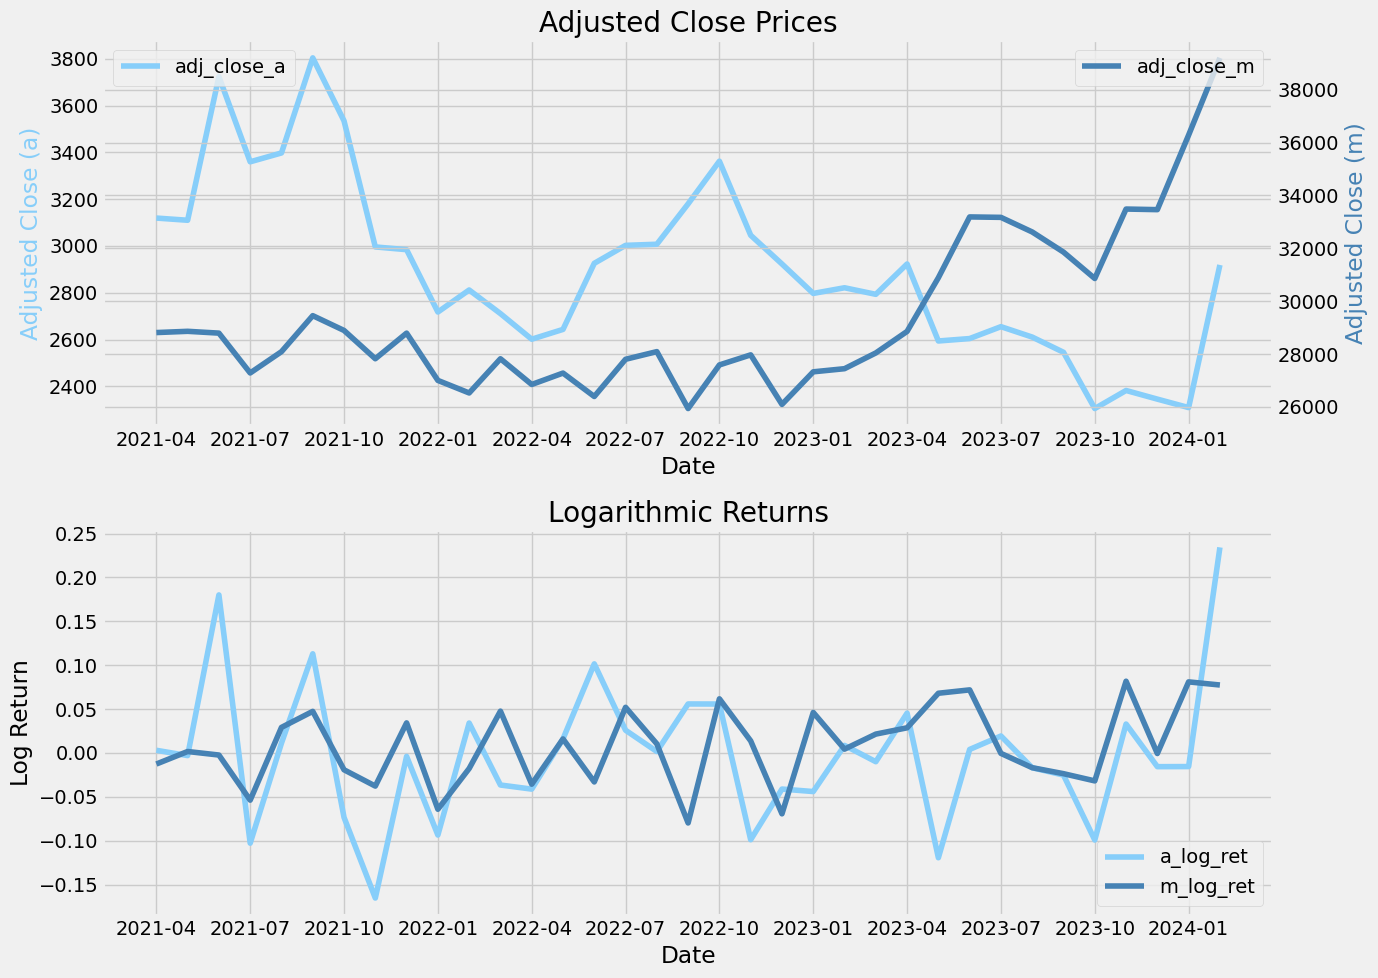

In [ ]:
# Vis Trend Plot
# Reset the index
merge_df_reset = M_adjClose_merge_df.reset_index()
merge_df_reset["YearMonth"] = merge_df_reset["Date"].dt.strftime('%Y-%m')

plt.figure(figsize=(14, 10))

# first plot
plt.subplot(2, 1, 1)
ax1 = plt.gca()  # primary axis
ax2 = ax1.twinx()  # Secondary axis

ax1.plot(merge_df_reset["YearMonth"], merge_df_reset['adj_close_a'], label='adj_close_a', color='lightskyblue')
ax2.plot(merge_df_reset['YearMonth'], merge_df_reset['adj_close_m'], label='adj_close_m', color='steelblue')

ax1.set_title('Adjusted Close Prices')
ax1.set_xlabel('Date')
ax1.set_ylabel('Adjusted Close (a)', color='lightskyblue')
ax2.set_ylabel('Adjusted Close (m)', color='steelblue')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

ax1.grid(True)

# Custom tick placement - 3 months apart
tick_indices = np.arange(0, len(merge_df_reset), 3)  # Get indices for every 3 months
ax1.set_xticks(tick_indices)
ax1.set_xticklabels(merge_df_reset['YearMonth'].iloc[tick_indices])

# second plot
plt.subplot(2, 1, 2)
plt.plot(merge_df_reset['YearMonth'], merge_df_reset['a_log_ret'], label='a_log_ret', color='lightskyblue')
plt.plot(merge_df_reset['YearMonth'], merge_df_reset['m_log_ret'], label='m_log_ret', color='steelblue')
plt.title('Logarithmic Returns')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.grid(True)

# Custom tick placement - 3 months apart
plt.xticks(tick_indices, merge_df_reset['YearMonth'].iloc[tick_indices])

plt.tight_layout()
plt.show()

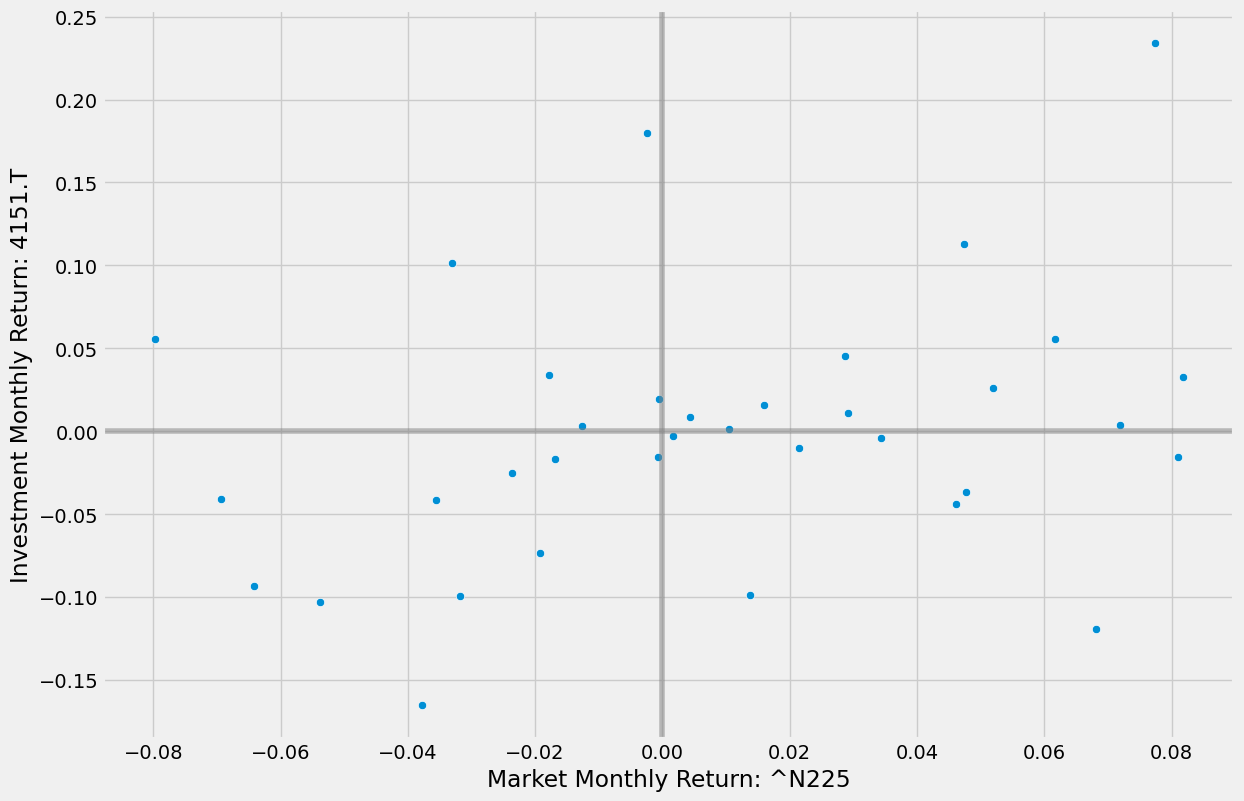

In [ ]:
# Vis Scatter Plot
plt.figure(figsize = (13,9))

plt.axvline(0, color='grey', alpha = 0.5)
plt.axhline(0, color='grey', alpha = 0.5)
sns.scatterplot(y = 'a_log_ret', x = 'm_log_ret', data = M_adjClose_merge_df)
plt.xlabel('Market Monthly Return: {}'.format(stock_m))
plt.ylabel('Investment Monthly Return: {}'.format(stock_e))
plt.show()

### Bayesian Linear Regression

In [ ]:
# Prepare Dataset
y = M_adjClose_merge_df["a_log_ret"].values
X = M_adjClose_merge_df["m_log_ret"].values

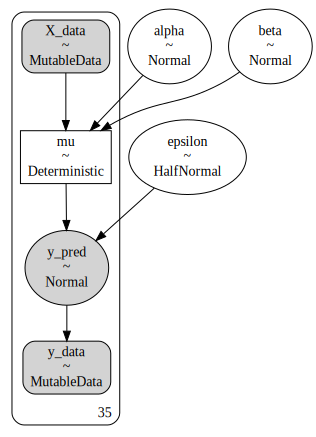

In [ ]:
# Define a Probabilistic Model
model = pm.Model()

with model:
    y_data = pm.Data("y_data", y, mutable=True)
    X_data = pm.Data("X_data", X, mutable=True)

    beta = pm.Normal("beta", mu=0, sigma=10)
    alpha = pm.Normal("alpha", mu=0, sigma=10)

    mu = pm.Deterministic("mu", beta * X_data + alpha)

    epsilon = pm.HalfNormal("epsilon", sigma=10)

    y_pred = pm.Normal("y_pred", mu=mu, sigma=epsilon, observed=y_data)

g = pm.model_to_graphviz(model)
display(g)

In [ ]:
# MCMC Sampling
with model:
    idata = pm.sample(
        chains = 2,
        tune = 1000,
        draws = 2000,
        random_seed = 42
    )

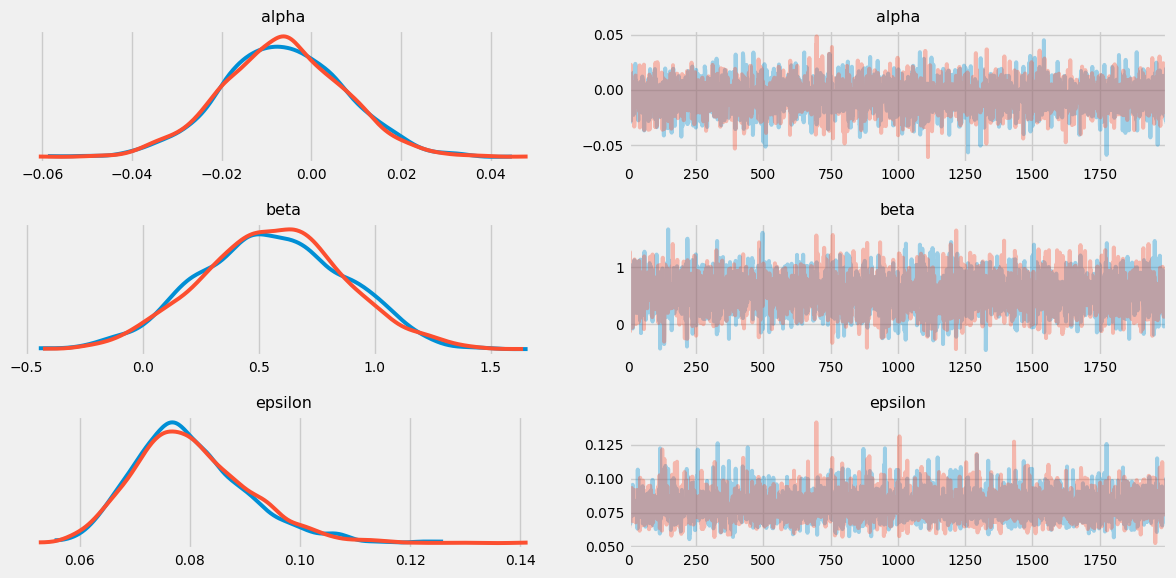

In [ ]:
# Visualize the Posterior Distribution
az.plot_trace(idata, compact=False, var_names=["alpha", "beta", "epsilon"])
plt.tight_layout();

In [ ]:
# Statistics of MCMC Samples
az.summary(idata, var_names=["alpha", "beta", "epsilon"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.006,0.014,-0.033,0.019,0.000,0.000,4794.0,3080.0,1.0
beta,0.559,0.315,-0.031,1.140,0.004,0.003,5316.0,3028.0,1.0
epsilon,0.080,0.010,0.061,0.099,0.000,0.000,4044.0,2781.0,1.0


In [ ]:
inf_beta = idata["posterior"]["beta"].values.reshape(4000, 1)
inf_alpha = idata["posterior"]["alpha"].values.reshape(4000, 1)

m_max = M_adjClose_merge_df["m_log_ret"].max()
m_min = M_adjClose_merge_df["m_log_ret"].min()
m_range = np.array([m_min, m_max]).reshape(1, 2)

a_preds = inf_beta @ m_range + inf_alpha

print(inf_beta)
print(inf_alpha)
print(m_range)
print(a_preds)

[[0.3441149 ]
 [0.67962849]
 [0.40026152]
 ...
 [0.19915417]
 [0.44772664]
 [0.61590242]]
[[-0.01382962]
 [ 0.00665602]
 [-0.01714407]
 ...
 [-0.00795531]
 [ 0.00360808]
 [ 0.00098535]]
[[-0.07978943  0.08173047]]
[[-0.04128636  0.01429505]
 [-0.04757115  0.06220237]
 [-0.04908071  0.01556949]
 ...
 [-0.0238457   0.00832166]
 [-0.03211577  0.04020099]
 [-0.04815715  0.05132335]]


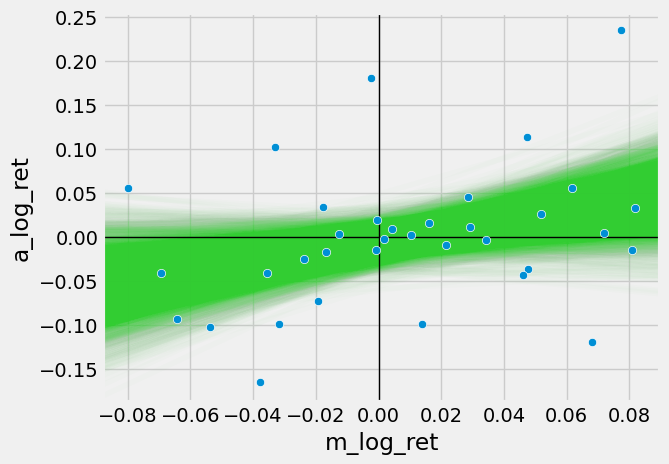

In [ ]:
# Bayesian Linear Regression
fig, ax = plt.subplots()

for a_pred in a_preds:
    ax1 = ax.axline((m_range[0][0], a_pred[0]), (m_range[0][1], a_pred[1]), alpha=0.01, c="limegreen", zorder=1)

ax2 = sns.scatterplot(y = 'a_log_ret', x = 'm_log_ret', data = M_adjClose_merge_df, zorder=3)

ax.axhline(0, color='black', linewidth=1, zorder=2)  # y=0の線
ax.axvline(0, color='black', linewidth=1, zorder=2)  # x=0の線

plt.show()

In [ ]:
# Get 90% Highest Density Interval
hdi_5 = az.hdi(idata, var_names=["beta"], hdi_prob=0.90).beta.values[0]
hdi_95 = az.hdi(idata, var_names=["beta"], hdi_prob=0.90).beta.values[1]

print(hdi_5)
print(hdi_95)

0.04890369148969975
1.0717725556577653


<Axes: >

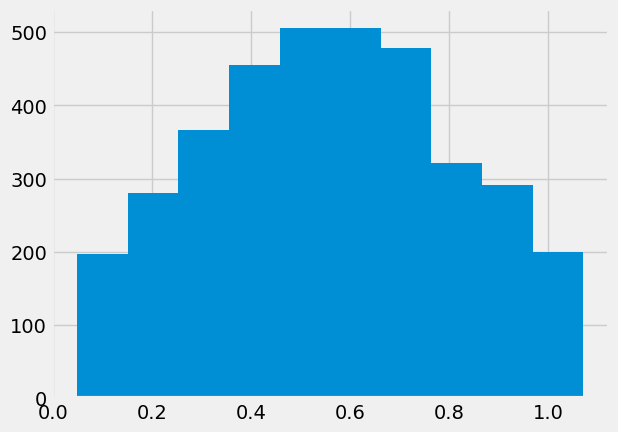

In [ ]:
# get beta and sort
beta_array = idata.posterior.beta.values.flatten()
sort_beta_li = np.sort(beta_array)

sort_beta_li = sort_beta_li[(sort_beta_li >= hdi_5) & (sort_beta_li <= hdi_95)] # 90% HDI
pd.Series(sort_beta_li).hist()

Text(0, 0.5, 'Frequency')

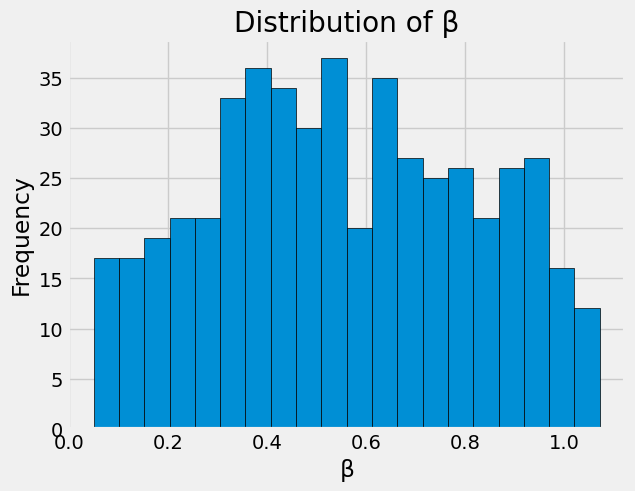

In [ ]:
# extract bunber
n_select = 500

# get extracted parameter
sampled_beta = np.random.choice(sort_beta_li, n_select, replace=False)

fig, ax = plt.subplots()
ax.hist(sampled_beta, bins=20, edgecolor='black')
ax.set_title('Distribution of β')
ax.set_xlabel('β')
ax.set_ylabel('Frequency')

In [ ]:
del idata

## Calculatation of WACC

In [ ]:
# WACC: Refer to Annual Securities Report for the Fiscal Year Ending December 2023

# cost of borrowing
interest_bearing_debt = (16111+17049+8136+25718)*1e6
interest_expenses = (5767 - 245/2 + 392 + 214)*1e6
cost_of_debt = interest_expenses / interest_bearing_debt
effective_tax_rate = 0.306

# cost of equity financeing(except for cost of equity)
market_capitalization = 1604880*1e6
market_portforio = 0.1140
risk_free_rate = 0.00877
market_risk_premium = market_portforio - risk_free_rate

print(effective_tax_rate)
print(cost_of_debt)

0.306
0.09327155519742143


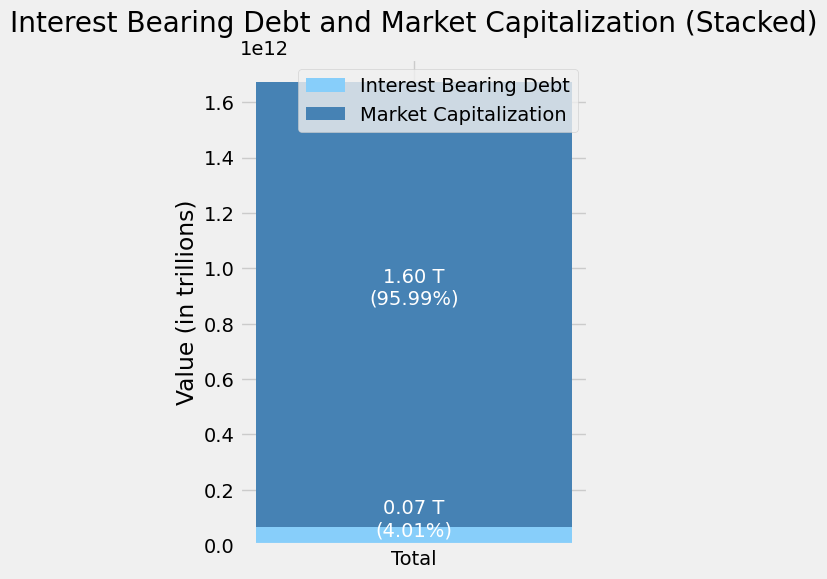

In [ ]:
# Total Value
total_value = interest_bearing_debt + market_capitalization

# Ratios
interest_bearing_debt_ratio = interest_bearing_debt / total_value * 100
market_capitalization_ratio = market_capitalization / total_value * 100

# Compile data
labels = ['Total']
interest_bearing_debt_values = [interest_bearing_debt]
market_capitalization_values = [market_capitalization]

# Vis Stacked bar graph
fig, ax = plt.subplots(figsize=(4, 6))  # 幅を半分にして高さを調整
bar_width = 0.4
ax.bar(labels, interest_bearing_debt_values, width=bar_width, color='lightskyblue', label='Interest Bearing Debt')
ax.bar(labels, market_capitalization_values, width=bar_width, bottom=interest_bearing_debt_values, color='steelblue', label='Market Capitalization')

# Set label
ax.set_ylabel('Value (in trillions)')
ax.set_title('Interest Bearing Debt and Market Capitalization (Stacked)')

# Display Value
ax.text(0, interest_bearing_debt / 2, f"{interest_bearing_debt / 1e12:.2f} T\n({interest_bearing_debt_ratio:.2f}%)", ha='center', color='white')
ax.text(0, interest_bearing_debt + market_capitalization / 2, f"{market_capitalization / 1e12:.2f} T\n({market_capitalization_ratio:.2f}%)", ha='center', color='white')

# Display a Legend
ax.legend()

plt.show()

Text(0, 0.5, 'Frequency')

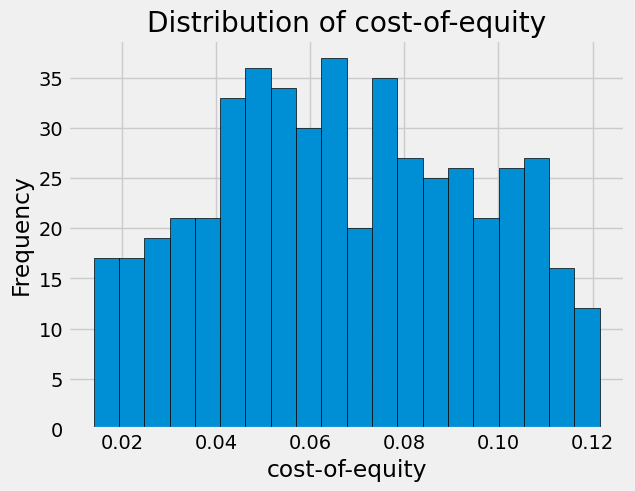

In [ ]:
# Cost of Equity
cost_of_equity_li = np.array(sampled_beta) * ( market_portforio - risk_free_rate ) + risk_free_rate

fig, ax = plt.subplots()
ax.hist(cost_of_equity_li, bins=20, edgecolor='black')
ax.set_title('Distribution of cost-of-equity')
ax.set_xlabel('cost-of-equity')
ax.set_ylabel('Frequency')

In [ ]:
# Wacc
D = interest_bearing_debt
E = market_capitalization
wacc_li = []
for cost_of_equity in cost_of_equity_li:
    wacc = (
        D / (D+E) * (1-effective_tax_rate) * cost_of_debt
        + E / (D+E) * cost_of_equity
    )
    wacc_li.append(wacc)

print(len(wacc_li))
print(min(wacc_li))
print(max(wacc_li))

500
0.01595290997501063
0.1192595660860668


Text(0, 0.5, 'Frequency')

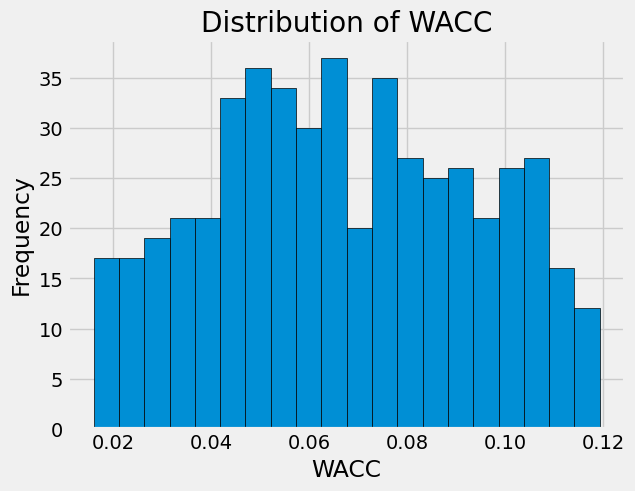

In [ ]:
fig, ax = plt.subplots()
ax.hist(np.array(wacc_li), bins=20, edgecolor='black')
ax.set_title('Distribution of WACC')
ax.set_xlabel('WACC')
ax.set_ylabel('Frequency')

## Calculation of Present Value and Trend of Future Value

In [ ]:
# ===Set Parameters===


# Fixed
num_scenarios = 500 # n Scenarios(n Simulation Runs)
prediction_period = 5 # Cash Flow Forecast Period (Years)
growth_rate = 0.1 # Growth Rate

# Uncertainty
std_growth_rate = 0.1 # Volatility　in Growth Rate
terminal_growth_rata = 0.0 # Perpetual Growth Rate


# Refer to Annual Securities Report for the Fiscal Year Ending December 2023
# Elements of Free Cash Flow
Ebit = 97246*1e6
Assumed_corporate_tax = 16058*1e6
Depreciation_expenses = 21096*1e6
Capital_expenditure = (17213 + 15639)*1e6
Increase_working_capital = ((119082+71363-92983) - (111746+70675-70922))*1e6
initial_FCFF = Ebit - Assumed_corporate_tax + Depreciation_expenses - Capital_expenditure - Increase_working_capital
print(initial_FCFF)

83469000000.0


In [ ]:
# Calculation
res_future_FCFF_li_2d = []
res_present_value_li = []
res_present_FCFF_li_2d = []

for required_rate_of_return in wacc_li:

    calc_result = monte_carlo_dcf_simulation(num_scenarios, prediction_period,
                                initial_FCFF, growth_rate, std_growth_rate,
                                terminal_growth_rata, required_rate_of_return)

    res_future_FCFF_li_2d.append(calc_result["future_FCFF_li_2d"])
    res_present_value_li.append(calc_result["present_value_li"])
    res_present_FCFF_li_2d.append(calc_result["present_FCFF_li_2d"])

In [ ]:
# get result
present_values = np.array(res_present_value_li).reshape(num_scenarios * n_select)
present_FCFF_array = np.array(res_present_FCFF_li_2d).reshape(num_scenarios * n_select, prediction_period)
future_FCFF_array = np.array(res_future_FCFF_li_2d).reshape(num_scenarios * n_select, prediction_period)

pres_value_median = round(np.median(present_values))
formatted_pres_value_median = f"{pres_value_median:,}"
pres_value_2_5_per = round(np.percentile(present_values, 2.5))
pres_value_97_5_per = round(np.percentile(present_values, 97.5))
formatted_pres_value_2_5_per = f"{pres_value_2_5_per:,}"
formatted_pres_value_97_5_per = f"{pres_value_97_5_per:,}"

print(present_values.shape)
print(present_FCFF_array.shape)
print(future_FCFF_array.shape)
print(formatted_pres_value_median)
print(formatted_pres_value_2_5_per)
print(formatted_pres_value_97_5_per)

(250000,)
(250000, 5)
(250000, 5)
1,966,586,430,319
1,087,011,270,138
6,451,091,889,895


Text(0, 0.5, 'Frequency')

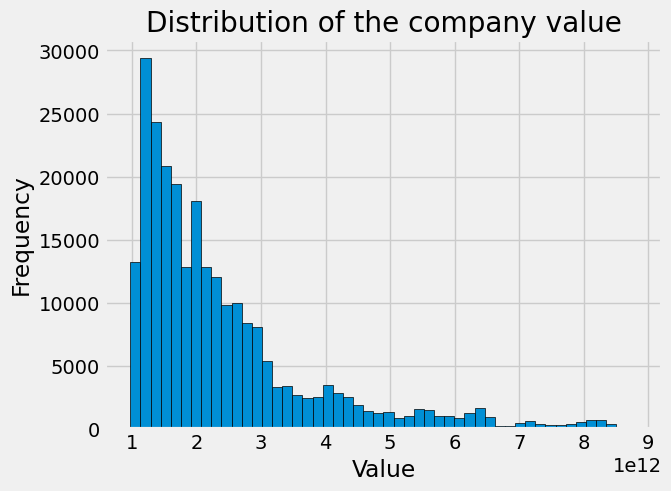

In [ ]:
# Histgram
fig, ax = plt.subplots()
ax.hist(present_values, bins=50, edgecolor='black')
ax.set_title('Distribution of the company value')
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')

Text(0, 0.5, 'value')

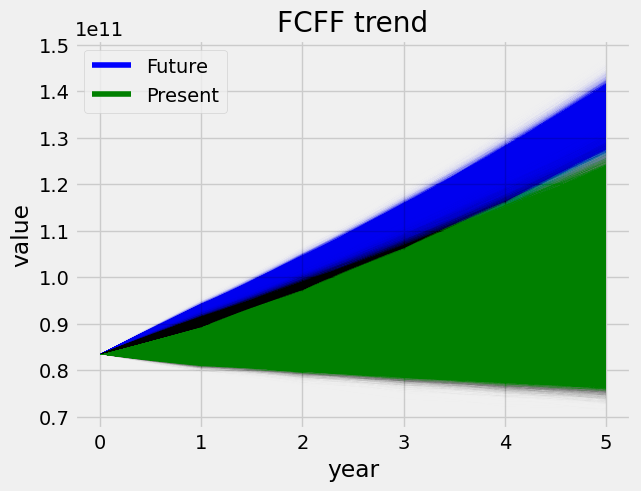

In [ ]:
# Trend
fig, ax = plt.subplots()

# Future Value
for row in future_FCFF_array:
    line_data = np.insert(row, 0, initial_FCFF)
    ax.plot(line_data, color="blue", linewidth=0.5, alpha=0.005)

# Present Value
for row in present_FCFF_array:
    line_data = np.insert(row, 0, initial_FCFF)
    ax.plot(line_data, color="green", linewidth=0.5, alpha=0.005)

# add legend
legend_elements = [Line2D([0], [0], color='blue', label='Future'),
                   Line2D([0], [0], color='green', label='Present')]
ax.legend(handles=legend_elements, loc='upper left')

ax.set_title('FCFF trend')
ax.set_xlabel('year')
ax.set_ylabel('value')